In [122]:
import pickle
import re
import os
import numpy as np
from numpy import array
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras import layers
import keras
import matplotlib.pyplot as plt
import helper
import tensorflow as tf
from keras import regularizers
from tensorflow import keras
from keras.optimizers import adam
import pandas as pd

import constants
import word_embeddings

In [193]:
X = helper.undump("../data/X_mid+20.pkl")
y = helper.undump("../data/y_mid+20.pkl")


print(X)
print(y)
print(len(X))
print(len(y))

[[ 6.49300000e-02  2.68593730e+00 -1.88615280e+00 ...  1.45925147e-30
   2.13757315e-26  2.56517078e-29]
 [ 2.41418200e+00  1.74597610e+00 -6.95424630e+00 ...  7.46531247e-56
   1.55572819e-47  1.42419334e-51]
 [-1.38486200e+00  2.07225960e+00 -1.13787800e+00 ...  3.42399657e-53
   2.95269368e-49  2.90869031e-51]
 ...
 [-1.02030000e-02  6.49805000e-01 -1.25386000e+00 ...  6.18782170e-47
   5.88180606e-41  5.93490367e-45]
 [-2.36761343e+00  3.05657972e+00 -6.32553370e+00 ...  1.31816808e-85
   1.41606376e-76  6.57419811e-64]
 [-1.90992000e+00  1.16124686e+00 -2.00774190e+00 ...  1.56161996e-46
   4.18658439e-42  1.93794969e-42]]
[ 0  0  0 ... 19 19 19]
100000
100000


In [194]:
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=1000)

def train_test_val_split(X, y, test_val_size, random_state):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_val_size, 
                                                        random_state=random_state)
    X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5, random_state=random_state)
    return [X_train, X_val, X_test, y_train, y_val, y_test]

X_train, X_val, X_test, y_train, y_val, y_test = train_test_val_split(X, y, 0.1, 1000)

print(X_train.shape)
print(X_test.shape)
print(X_val.shape)
input_dim = X_train.shape[1] # number of features

(90000, 320)
(5000, 320)
(5000, 320)


In [385]:
epochs = 8
def accuracy(y_predict, y_t):
        count = 0
        total = len(y_predict)
        for i in range(total):
            if (y_predict[i] == y_t[i]):
                count += 1
        acc = 100 *float(count) / total
        print("Final Test accuracy is: {}%".format(acc))
        return acc

def print_acc(model, history):
    hist = pd.DataFrame(history.history)
    train_acc_vec = hist.pop("acc")
    val_acc_vec = hist.pop("val_acc")
    finalTrainAcc = train_acc_vec[len(train_acc_vec) - 1]
    finalValAcc = val_acc_vec[len(val_acc_vec) - 1]
    print("Final training accuracy: {}%".format(finalTrainAcc*100))
    print("Final validation accuracy: {}%".format(finalValAcc*100))
    
# Plot metrics
def plot_history(history, xlimit=epochs):
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch

    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Cross Entropy Error')
    plt.plot(hist['epoch'], hist['loss'],
           label='Train Error')
    plt.plot(hist['epoch'], hist['val_loss'],
           label = 'Val Error')
    plt.xlim([0,xlimit])
    plt.ylim([1,4])
    plt.legend()
    plt.show()

In [386]:
# Model Definitions

# Original model by austin
def build_model_A():
    model = Sequential()
    
    #Input Layer
    model.add(layers.Dense(20, input_dim=input_dim, activation='relu', use_bias=True))
    
    #Hidden Layers
    #None
    
    #Output Layer
    model.add(layers.Dense(20, activation='softmax'))
    model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['acc'])
    return model

# Modified models
def build_model_B(learning_rate, dropout, reg, num_neurons, num_layers):
    model = Sequential()
    
    
    #Input Layer
    model.add(layers.Dense(200, input_dim=input_dim, activation='relu', 
                           use_bias=True, activity_regularizer=regularizers.l2(reg)))
    
    #Hidden Layers
    model.add(layers.Dense(200, activation='relu', use_bias=True, activity_regularizer=regularizers.l2(reg)))
    model.add(layers.Dropout(dropout))
    model.add(layers.Dense(150, activation='relu', use_bias=True, activity_regularizer=regularizers.l2(reg)))
    model.add(layers.Dense(130, activation='relu', use_bias=True, activity_regularizer=regularizers.l2(reg)))
    model.add(layers.Dense(90, activation='relu', use_bias=True, activity_regularizer=regularizers.l2(reg)))
    
    #Output Layer
    model.add(layers.Dense(20, activation='softmax'))
    
    # Optimizer. Can change this to whatever we want
    opt = adam(lr=learning_rate)
    model.compile(loss='sparse_categorical_crossentropy', optimizer=opt, metrics=['acc'])
    return model

In [223]:
# Build Models and Summary
model_A = build_model_A()
model_A.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_75 (Dense)             (None, 20)                6420      
_________________________________________________________________
dense_76 (Dense)             (None, 20)                420       
Total params: 6,840
Trainable params: 6,840
Non-trainable params: 0
_________________________________________________________________


In [224]:
model_A_history = model_A.fit(X_train, y_train, epochs=epochs, verbose=1,
         validation_data=(X_val, y_val))

Train on 90000 samples, validate on 5000 samples
Epoch 1/40
90000/90000 [==============================] - 5s 59us/step - loss: 2.8558 - acc: 0.1042 - val_loss: 2.5654 - val_acc: 0.1718
Epoch 2/40
90000/90000 [==============================] - 4s 50us/step - loss: 2.4285 - acc: 0.2258 - val_loss: 2.3371 - val_acc: 0.2772
Epoch 3/40
90000/90000 [==============================] - 4s 49us/step - loss: 2.3133 - acc: 0.2736 - val_loss: 2.2584 - val_acc: 0.2956
Epoch 4/40
90000/90000 [==============================] - 4s 49us/step - loss: 2.2520 - acc: 0.2999 - val_loss: 2.3570 - val_acc: 0.2704
Epoch 5/40
90000/90000 [==============================] - 4s 49us/step - loss: 2.2248 - acc: 0.3110 - val_loss: 2.2244 - val_acc: 0.3074
Epoch 6/40
90000/90000 [==============================] - 4s 50us/step - loss: 2.2071 - acc: 0.3161 - val_loss: 2.1850 - val_acc: 0.3260
Epoch 7/40
90000/90000 [==============================] - 4s 49us/step - loss: 2.1818 - acc: 0.3238 - val_loss: 2.1588 - val_acc:

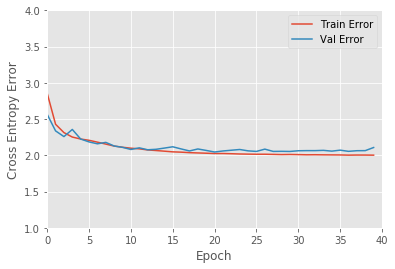

In [225]:
plot_history(model_A_history)

In [226]:
# accuracies
X_test_copy = np.copy(X_test)
y_predict_prob = model_A.predict(X_test_copy)
y_predict = y_predict_prob.argmax(axis=-1)
    
    
accuracy(y_predict, y_test)

print_acc(model_A, model_A_history)

Final Test accuracy is: 37.34%
Final training accuracy: 39.14666666666667%
Final validation accuracy: 37.28%


In [387]:
learning_rate = 0.1
dropout=0
reg=0.0
model_B = build_model_B(learning_rate=0.001, dropout=0, reg=0.00,num_neurons=5,num_layers=10)
model_B.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_290 (Dense)            (None, 200)               64200     
_________________________________________________________________
dense_291 (Dense)            (None, 200)               40200     
_________________________________________________________________
dropout_17 (Dropout)         (None, 200)               0         
_________________________________________________________________
dense_292 (Dense)            (None, 150)               30150     
_________________________________________________________________
dense_293 (Dense)            (None, 130)               19630     
_________________________________________________________________
dense_294 (Dense)            (None, 90)                11790     
_________________________________________________________________
dense_295 (Dense)            (None, 20)                1820      
Total para

In [388]:
%%time
model_B_history = model_B.fit(X_train, y_train, epochs=epochs, verbose=1,
         validation_data=(X_val, y_val))

Train on 90000 samples, validate on 5000 samples
Epoch 1/8
90000/90000 [==============================] - 20s 221us/step - loss: 2.3252 - acc: 0.2825 - val_loss: 2.1018 - val_acc: 0.3610
Epoch 2/8
90000/90000 [==============================] - 16s 174us/step - loss: 2.0540 - acc: 0.3701 - val_loss: 2.0553 - val_acc: 0.3798
Epoch 3/8
90000/90000 [==============================] - 15s 165us/step - loss: 1.9860 - acc: 0.3937 - val_loss: 1.9835 - val_acc: 0.3838
Epoch 4/8
90000/90000 [==============================] - 15s 165us/step - loss: 1.9408 - acc: 0.4064 - val_loss: 2.0052 - val_acc: 0.3906
Epoch 5/8
90000/90000 [==============================] - 15s 172us/step - loss: 1.9116 - acc: 0.4148 - val_loss: 1.9904 - val_acc: 0.3962
Epoch 6/8
90000/90000 [==============================] - 16s 177us/step - loss: 1.8879 - acc: 0.4226 - val_loss: 1.9589 - val_acc: 0.4098
Epoch 7/8
90000/90000 [==============================] - 17s 185us/step - loss: 1.8667 - acc: 0.4306 - val_loss: 1.9444 - v

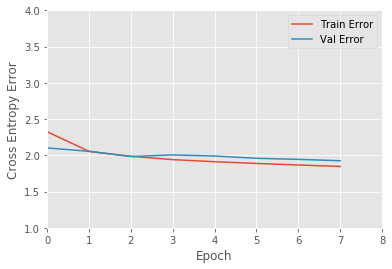

In [389]:
plot_history(model_B_history)

In [390]:
X_test_copy = np.copy(X_test)
y_predict_prob = model_B.predict(X_test_copy)

y_predict = y_predict_prob.argmax(axis=-1)
    
    
accuracy(y_predict, y_test)

print_acc(model_B, model_B_history)

Final Test accuracy is: 41.08%
Final training accuracy: 43.67666666666667%
Final validation accuracy: 41.82%


In [327]:
def test_max_neurons(num_neurons, start_n):
    max_neurons = 0
    max_acc = 0
    for i in range(start_n, num_neurons + 1):
        model = build_model_B(learning_rate=learning_rate, reg=reg,dropout=dropout, num_neurons=i, num_layers=1)
        model_history = model.fit(X_train, y_train, epochs=epochs, verbose=1,
         validation_data=(X_val, y_val))
        plot_history(model_history)
        
        X_test_copy = np.copy(X_test)
        y_predict_prob = model.predict(X_test_copy)
        y_predict = y_predict_prob.argmax(axis=-1)

        
        temp_acc = accuracy(y_predict, y_test)
        if temp_acc > max_acc:
            max_acc = temp_acc
            max_neurons = i
        print_acc(model, model_history)
        print("Num Neurons: {} \nCurrent Max Neurons= {}\nCurrent Max Accuracy={}".format(i, max_neurons, max_acc))
        
    print("max neurons: {}\n max accuracy: {}".format(max_neurons, max_acc))
        

In [328]:
num_neurons=9
num_layers=1

Train on 90000 samples, validate on 5000 samples
Epoch 1/15
90000/90000 [==============================] - 11s 123us/step - loss: 3.0006 - acc: 0.0500 - val_loss: 2.9963 - val_acc: 0.0474
Epoch 2/15
90000/90000 [==============================] - 8s 89us/step - loss: 2.8085 - acc: 0.0997 - val_loss: 2.6017 - val_acc: 0.1444
Epoch 3/15
90000/90000 [==============================] - 8s 89us/step - loss: 2.4871 - acc: 0.1907 - val_loss: 2.4687 - val_acc: 0.2016
Epoch 4/15
90000/90000 [==============================] - 8s 90us/step - loss: 2.3811 - acc: 0.2335 - val_loss: 2.3582 - val_acc: 0.2452
Epoch 5/15
90000/90000 [==============================] - 8s 90us/step - loss: 2.3409 - acc: 0.2492 - val_loss: 2.3265 - val_acc: 0.2526
Epoch 6/15
90000/90000 [==============================] - 8s 89us/step - loss: 2.3140 - acc: 0.2595 - val_loss: 2.2987 - val_acc: 0.2674
Epoch 7/15
90000/90000 [==============================] - 8s 89us/step - loss: 2.2902 - acc: 0.2692 - val_loss: 2.2900 - val_ac

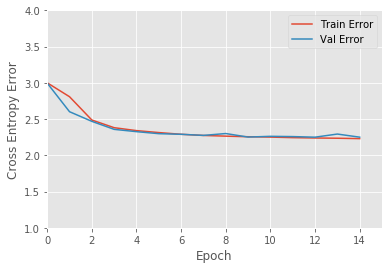

Final Test accuracy is: 28.3%
Final training accuracy: 28.71%
Final validation accuracy: 28.860000000000003%
Num Neurons: 5 
Current Max Neurons= 5
Current Max Accuracy=28.3
Train on 90000 samples, validate on 5000 samples
Epoch 1/15
90000/90000 [==============================] - 11s 124us/step - loss: 2.6755 - acc: 0.1400 - val_loss: 2.4884 - val_acc: 0.1762
Epoch 2/15
90000/90000 [==============================] - 8s 90us/step - loss: 2.4027 - acc: 0.2266 - val_loss: 2.3422 - val_acc: 0.2506
Epoch 3/15
90000/90000 [==============================] - 8s 90us/step - loss: 2.3309 - acc: 0.2499 - val_loss: 2.3365 - val_acc: 0.2576
Epoch 4/15
90000/90000 [==============================] - 8s 90us/step - loss: 2.3035 - acc: 0.2616 - val_loss: 2.3090 - val_acc: 0.2774
Epoch 5/15
90000/90000 [==============================] - 8s 92us/step - loss: 2.2816 - acc: 0.2722 - val_loss: 2.2778 - val_acc: 0.2848
Epoch 6/15
90000/90000 [==============================] - 8s 91us/step - loss: 2.2584 - ac

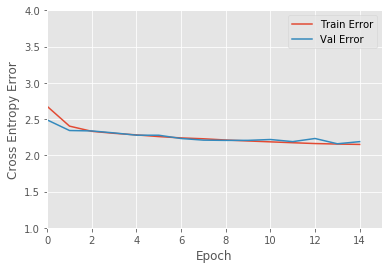

Final Test accuracy is: 32.72%
Final training accuracy: 32.748888888888885%
Final validation accuracy: 32.06%
Num Neurons: 6 
Current Max Neurons= 6
Current Max Accuracy=32.72
Train on 90000 samples, validate on 5000 samples
Epoch 1/15
90000/90000 [==============================] - 11s 123us/step - loss: 2.8259 - acc: 0.1113 - val_loss: 2.5615 - val_acc: 0.1618
Epoch 2/15
90000/90000 [==============================] - 8s 89us/step - loss: 2.4443 - acc: 0.2162 - val_loss: 2.3563 - val_acc: 0.2486
Epoch 3/15
90000/90000 [==============================] - 8s 90us/step - loss: 2.3242 - acc: 0.2583 - val_loss: 2.3206 - val_acc: 0.2658
Epoch 4/15
90000/90000 [==============================] - 8s 90us/step - loss: 2.2772 - acc: 0.2735 - val_loss: 2.2445 - val_acc: 0.2852
Epoch 5/15
90000/90000 [==============================] - 8s 90us/step - loss: 2.2396 - acc: 0.2856 - val_loss: 2.2222 - val_acc: 0.2924
Epoch 6/15
90000/90000 [==============================] - 8s 90us/step - loss: 2.2143 - 

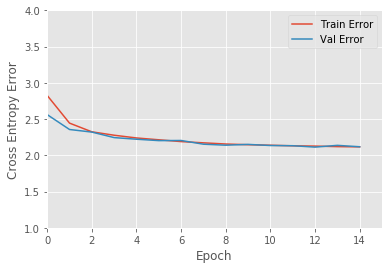

Final Test accuracy is: 32.72%
Final training accuracy: 33.794444444444444%
Final validation accuracy: 34.06%
Num Neurons: 7 
Current Max Neurons= 6
Current Max Accuracy=32.72
Train on 90000 samples, validate on 5000 samples
Epoch 1/15
90000/90000 [==============================] - 11s 127us/step - loss: 2.7668 - acc: 0.1260 - val_loss: 2.4914 - val_acc: 0.1940
Epoch 2/15
90000/90000 [==============================] - 8s 92us/step - loss: 2.4120 - acc: 0.2202 - val_loss: 2.3410 - val_acc: 0.2462
Epoch 3/15
90000/90000 [==============================] - 8s 92us/step - loss: 2.3034 - acc: 0.2623 - val_loss: 2.2934 - val_acc: 0.2554
Epoch 4/15
90000/90000 [==============================] - 8s 92us/step - loss: 2.2485 - acc: 0.2819 - val_loss: 2.2445 - val_acc: 0.2904
Epoch 5/15
90000/90000 [==============================] - 8s 92us/step - loss: 2.2210 - acc: 0.2936 - val_loss: 2.2015 - val_acc: 0.3088
Epoch 6/15
90000/90000 [==============================] - 8s 93us/step - loss: 2.2003 - 

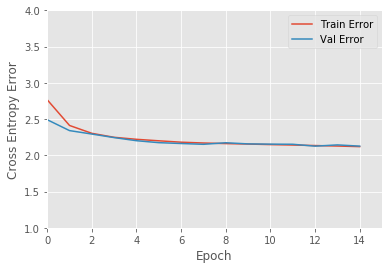

Final Test accuracy is: 33.52%
Final training accuracy: 34.03%
Final validation accuracy: 33.68%
Num Neurons: 8 
Current Max Neurons= 8
Current Max Accuracy=33.52
Train on 90000 samples, validate on 5000 samples
Epoch 1/15
90000/90000 [==============================] - 11s 128us/step - loss: 2.7144 - acc: 0.1352 - val_loss: 2.4231 - val_acc: 0.2074
Epoch 2/15
90000/90000 [==============================] - 8s 93us/step - loss: 2.3557 - acc: 0.2319 - val_loss: 2.3074 - val_acc: 0.2516
Epoch 3/15
90000/90000 [==============================] - 8s 89us/step - loss: 2.2871 - acc: 0.2579 - val_loss: 2.3033 - val_acc: 0.2646
Epoch 4/15
90000/90000 [==============================] - 8s 92us/step - loss: 2.2537 - acc: 0.2739 - val_loss: 2.2608 - val_acc: 0.2776
Epoch 5/15
90000/90000 [==============================] - 9s 101us/step - loss: 2.2271 - acc: 0.2862 - val_loss: 2.2279 - val_acc: 0.2946
Epoch 6/15
90000/90000 [==============================] - 9s 97us/step - loss: 2.2074 - acc: 0.2948 

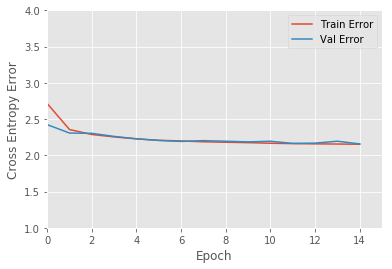

Final Test accuracy is: 31.32%
Final training accuracy: 31.572222222222223%
Final validation accuracy: 31.04%
Num Neurons: 9 
Current Max Neurons= 8
Current Max Accuracy=33.52
max neurons: 8
 max accuracy: 33.52


In [329]:
test_max_neurons(num_neurons=num_neurons, start_n=5)